In [1]:
%cd ..

/home/ubuntu/OptiServe


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import itertools
import boto3
import json
import os

from src.modeling.application_performance_modeling import ApplicationPerformanceModeling
from src.analytics.aws_function_logs import AWSFunctionLogs
from src.profiler.cost_calculator import CostCalculator
from src.modeling.function_performance_modeling import FunctionPerformanceModeling
from src.optimizer.application_optimizer import ApplicationOptimizer

In [3]:
lambda_functions = [
    'f1',
    'yolo',
    'resnet'
]

resnet_variants = [
    'resnet-18',
    'resnet-34',
    'resnet-50',
    'resnet-101'
]

bert_variants = [
    'distilbert-base-uncased',
    'bert-base-uncased'
]

yolo_variants = [
    'yolov10n',
    'yolov10s',
    'yolov10m',
    'yolov10l'
]

default_function_variants = ['None']

ml_data_bucket = 'test-images-mohammad'

In [4]:
modeled_functions_dir = 'modeled_functions/'

os.makedirs(modeled_functions_dir, exist_ok=True)

for f in lambda_functions:
    memory_bound = (128, 3008)
    
    if f == 'resnet' or f == 'yolo':
        memory_bound = [(1024, 10000)]
        variants = resnet_variants if f == 'resnet' else yolo_variants
        for var in variants:
            if os.path.exists(modeled_functions_dir + f + '_' + var + '.mdl'):
                print(f"Performance model for {f} with variant {var} already exists. Skipping...")
                continue
            payload = {
                'bucket_name': ml_data_bucket,
                'num_images': 24,
                'batch_size': 4,
                'model_name': var,
            }
            p_model = FunctionPerformanceModeling(
                function_name=f,
                payload=json.dumps(payload),
                memory_bounds=memory_bound,
                profiling_iterations=3,
                available_models=[var],
            ).get_performance_model()
            p_model.save(modeled_functions_dir + f + '_' + var + '.mdl')
            del p_model
            
        
    elif f == 'bert':
        memory_bound = [(2048, 10000)]
        for var in bert_variants:
            if os.path.exists(modeled_functions_dir + f + '_' + var + '.mdl'):
                print(f"Performance model for {f} with variant {var} already exists. Skipping...")
                continue
            payload = {
                'model_name': var
            }
            p_model = FunctionPerformanceModeling(
                function_name=f,
                payload=json.dumps(payload),
                memory_bounds=memory_bound,
                profiling_iterations=3,
                available_models=[var],
            ).get_performance_model()
            p_model.save(modeled_functions_dir + f + '_' + var + '.mdl')
            del p_model
    
    else:
        if os.path.exists(modeled_functions_dir + f + '.mdl'):
            print(f"Performance model for {f} already exists. Skipping...")
            continue
        p_model = FunctionPerformanceModeling(
            function_name=f,
            payload=json.dumps({}),
            memory_bounds=memory_bound,
            profiling_iterations=3,
        ).get_performance_model()
        p_model.save(modeled_functions_dir + f + '.mdl')
        del p_model

Performance model for f1 already exists. Skipping...
Performance model for yolo with variant yolov10n already exists. Skipping...
Performance model for yolo with variant yolov10s already exists. Skipping...
Performance model for yolo with variant yolov10m already exists. Skipping...
Performance model for yolo with variant yolov10l already exists. Skipping...
Performance model for resnet with variant resnet-18 already exists. Skipping...
Performance model for resnet with variant resnet-34 already exists. Skipping...
Performance model for resnet with variant resnet-50 already exists. Skipping...
Performance model for resnet with variant resnet-101 already exists. Skipping...


In [5]:
from src.optimizer.parametric_function import ParamFunction


perf_profile = {
    'f1': [{}],
    'yolo': [{} for _ in yolo_variants],
    'resnet': [{} for _ in resnet_variants]
}

mem_list = list(range(128, 3072, 192))
resnet_mem_list = list(range(2048, 10000, 512))
bert_mem_list = list(range(2048, 10000, 800))
yolo_mem_list = list(range(2048, 10000, 800))

for function in lambda_functions:
    if function == 'resnet':
        for i, var in enumerate(resnet_variants):
            p_model = ParamFunction.load('modeled_functions/' + function + '_' + var + '.mdl')
            perf_profile[function][i] = {mem: p_model(mem) for mem in resnet_mem_list}
    elif function == 'bert':
        for i, var in enumerate(bert_variants):
            p_model = ParamFunction.load('modeled_functions/' + function + '_' + var + '.mdl')
            perf_profile[function][i] = {mem: p_model(mem) for mem in bert_mem_list}
    elif function == 'yolo':
        for i, var in enumerate(yolo_variants):
            p_model = ParamFunction.load('modeled_functions/' + function + '_' + var + '.mdl')
            perf_profile[function][i] = {mem: p_model(mem) for mem in yolo_mem_list}
    else:
        p_model = ParamFunction.load('modeled_functions/' + function + '.mdl')
        perf_profile[function][0] = {mem: p_model(mem) for mem in mem_list}

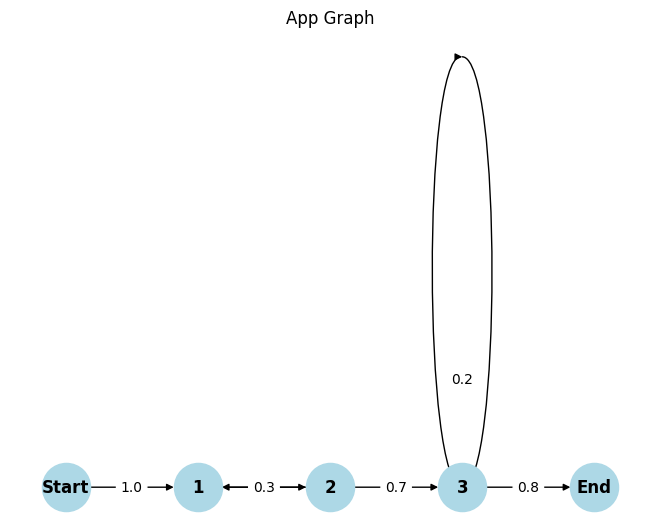

In [6]:
App_G = nx.DiGraph()

App_G.add_node('Start', pos=(0, 0))
App_G.add_node(1, pos=(1, 0), perf_profile=perf_profile['f1'], models_list=default_function_variants)
App_G.add_node(2, pos=(2, 0), perf_profile=perf_profile['resnet'], models_list=resnet_variants)
App_G.add_node(3, pos=(3, 0), perf_profile=perf_profile['yolo'], models_list=yolo_variants)
App_G.add_node('End', pos=(4, 0))

App_G.add_weighted_edges_from([
    ('Start', 1, 1.0),
    (1, 2, 1.0),
    (2, 1, 0.3),
    (2, 3, 0.7),
    (3, 3, 0.2),
    (3, 'End', 0.8),
])

pos = nx.get_node_attributes(App_G, 'pos')
nx.draw(App_G, pos, with_labels=True, node_size=1200, node_color='lightblue', font_weight='bold', arrows=True)

labels = nx.get_edge_attributes(App_G, 'weight')
nx.draw_networkx_edge_labels(App_G, pos, edge_labels=labels)


plt.title("App Graph")
plt.axis('off')
plt.tight_layout()
plt.show()

In [7]:
application_name = 'App3'
number_of_workers = 6
number_of_configurations = 1
pct_data_folder = 'perf_cost_data'
os.makedirs(pct_data_folder, exist_ok=True)

for function in lambda_functions:
    number_of_configurations *= len(perf_profile[function]) * len(perf_profile[function][0])
    
print('number of configs ', number_of_configurations)

pct_filename_list = [pct_data_folder + '/' + application_name+'_part'+str(n) +'.csv' for n in range(1, number_of_workers+1)]
pct_start_iterations_list = [int(number_of_configurations/number_of_workers * (n-1))+1 for n in range(1, number_of_workers+1)]
pct_end_iterations_list = [n-1 for n in pct_start_iterations_list[1:]]
pct_end_iterations_list.append(number_of_configurations)

number of configs  40960


In [8]:
from multiprocessing import Process
import multiprocessing as mp
from src.utils.pct_work import pct_work
mp.set_start_method("spawn", force=True)

    
processes = []

for i in range(number_of_workers):
    p = Process(target=pct_work, args=(App_G, pct_filename_list[i], pct_start_iterations_list[i], pct_end_iterations_list[i], {}, {}))
    p.start()
    processes.append(p)

for p in processes:
    p.join()

Minimal Memory Configuration: {1: 128, 2: 2048, 3: 2048}
Maximal Memory Configuration: {1: 3008, 2: 9728, 3: 9248}
Maximal Model Configuration: {1: 0, 2: 3, 3: 3}
Minimal Model Configuration: {1: 0, 2: 0, 3: 0}
Maximal Cost: 2728.3120025892854
Minimal Average Response Time: 2955.310512560271
Minimal Cost: 321.7714752321429
Maximal Average Response Time: 81280.22142232305
Optimization Boundary Calculation Completed.
Minimal Memory Configuration: {1: 128, 2: 2048, 3: 2048}
Maximal Memory Configuration: {1: 3008, 2: 9728, 3: 9248}
Maximal Model Configuration: {1: 0, 2: 3, 3: 3}
Minimal Model Configuration: {1: 0, 2: 0, 3: 0}
Maximal Cost: 2728.3120025892854
Minimal Average Response Time: 2955.310512560271
Minimal Cost: 321.7714752321429
Maximal Average Response Time: 81280.22142232305
Optimization Boundary Calculation Completed.
Minimal Memory Configuration: {1: 128, 2: 2048, 3: 2048}
Maximal Memory Configuration: {1: 3008, 2: 9728, 3: 9248}
Maximal Model Configuration: {1: 0, 2: 3, 3: 3}

100%|██████████| 6826/6826 [00:06<00:00, 1091.10it/s]


In [9]:
import pandas as pd

data_parts_list = []

for filename in pct_filename_list:
    data_parts = pd.read_csv(filename)
    data_parts_list.append(data_parts)

perf_cost_data = pd.concat(data_parts_list, ignore_index=True)

# Reorder columns
perf_cost_data.index = range(1, perf_cost_data.shape[0] + 1)

perf_cost_data

,ID,f1_mem,f2_mem,f3_mem,f1_acc,f2_acc,f3_acc,f1_acc_value,f2_acc_value,f3_acc_value,Cost,RT
1,1,128,2048,2048,0,0,0,1.0,0.25,0.25,321.771475,13922.044087
2,2,128,2048,2848,0,0,0,1.0,0.25,0.25,341.622426,12602.774420
3,3,128,2048,3648,0,0,0,1.0,0.25,0.25,348.770227,11647.700878
4,4,128,2048,4448,0,0,0,1.0,0.25,0.25,350.142626,10956.283882
5,5,128,2048,5248,0,0,0,1.0,0.25,0.25,349.849656,10455.738697
...,...,...,...,...,...,...,...,...,...,...,...,...
40956,40956,3008,9728,6048,0,3,3,1.0,1.00,1.00,3102.905851,29930.733437
40957,40957,3008,9728,6848,0,3,3,1.0,1.00,1.00,3014.328200,26061.323264
40958,40958,3008,9728,7648,0,3,3,1.0,1.00,1.00,2916.494020,22928.124596
40959,40959,3008,9728,8448,0,3,3,1.0,1.00,1.00,2819.208018,20391.062498


In [10]:
min_cost_row = perf_cost_data.loc[perf_cost_data['Cost'].idxmin()]
max_cost_row = perf_cost_data.loc[perf_cost_data['Cost'].idxmax()]
min_rt_row   = perf_cost_data.loc[perf_cost_data['RT'].idxmin()]
max_rt_row   = perf_cost_data.loc[perf_cost_data['RT'].idxmax()]

# Define columns to extract
config_cols = ['f1_mem', 'f2_mem', 'f3_mem', 'f1_acc', 'f2_acc', 'f3_acc']
value_cols = ['Cost', 'RT']

# Print results
print("🔹 Minimal Cost Config:")
print(min_cost_row[config_cols])
print(f"Cost: {min_cost_row['Cost']}, RT: {min_cost_row['RT']}\n")

print("🔹 Maximal Cost Config:")
print(max_cost_row[config_cols])
print(f"Cost: {max_cost_row['Cost']}, RT: {max_cost_row['RT']}\n")

print("🔹 Minimal RT Config:")
print(min_rt_row[config_cols])
print(f"Cost: {min_rt_row['Cost']}, RT: {min_rt_row['RT']}\n")

print("🔹 Maximal RT Config:")
print(max_rt_row[config_cols])
print(f"Cost: {max_rt_row['Cost']}, RT: {max_rt_row['RT']}")

🔹 Minimal Cost Config:
f1_mem    1088.0
f2_mem    5120.0
f3_mem    2048.0
f1_acc       0.0
f2_acc       0.0
f3_acc       0.0
Name: 861, dtype: float64
Cost: 303.9767967857143, RT: 7864.411355375111

🔹 Maximal Cost Config:
f1_mem    3008.0
f2_mem    9728.0
f3_mem    4448.0
f1_acc       0.0
f2_acc       3.0
f3_acc       3.0
Name: 40954, dtype: float64
Cost: 3190.8396203510047, RT: 40610.78966921648

🔹 Minimal RT Config:
f1_mem    3008.0
f2_mem    9728.0
f3_mem    9248.0
f1_acc       0.0
f2_acc       0.0
f3_acc       0.0
Name: 2560, dtype: float64
Cost: 394.7072609843751, RT: 2955.310512560271

🔹 Maximal RT Config:
f1_mem     128.0
f2_mem    2048.0
f3_mem    2048.0
f1_acc       0.0
f2_acc       3.0
f3_acc       3.0
Name: 38401, dtype: float64
Cost: 2567.037870517857, RT: 81280.22142232305


In [ ]:
app3_ocd_budget_num_of_points = 10
app3_ocd_performance_constraint_num_of_points = 10
app3_ocd_accuracy_constraint_num_of_points = 10

min_max_accuracy_per_function = {
    'f1': (1 / len(default_function_variants), 1),
    'yolo': (1 / len(yolo_variants), 1),
    'resnet': (1 / len(resnet_variants), 1)
}


app3_ocd_accuracy_formula = lambda a0, a1, a2: 2 * a1 + a2
min_accuracy_value = app3_ocd_accuracy_formula(*[v[0] for v in min_max_accuracy_per_function.values()])
max_accuracy_value = app3_ocd_accuracy_formula(*[v[1] for v in min_max_accuracy_per_function.values()])

app3_ocd_accuracy_constraint_list = list(np.linspace(min_accuracy_value, max_accuracy_value, app3_ocd_accuracy_constraint_num_of_points))

opt_curve_dir = 'opt_curve_data/'
os.makedirs(opt_curve_dir, exist_ok=True)
app3_ocd_filenameprefix = f'{opt_curve_dir}App3'

In [16]:
def ocd_work(App_G, filenameprefix, budget_num, performance_constraint_num, accuracy_constraint_list, accuracy_formula, mem_list, model_list):
    App = ApplicationPerformanceModeling(graph=App_G.copy())
    optimizer = ApplicationOptimizer(App, mem_list=mem_list, model_list=model_list)
    optimizer.get_opt_curve(filenameprefix=filenameprefix,
                            budget_list=list(np.linspace(optimizer.minimal_cost, optimizer.maximal_cost, budget_num)),
                            performance_constraint_list=list(np.linspace(optimizer.minimal_avg_rt, optimizer.maximal_avg_rt, performance_constraint_num)),
                            accuracy_constraint_list=accuracy_constraint_list,
                            accuracy_formula=accuracy_formula)

In [17]:
%%capture
ocd_work(App_G, app3_ocd_filenameprefix, app3_ocd_budget_num_of_points, app3_ocd_performance_constraint_num_of_points, app3_ocd_accuracy_constraint_list, app3_ocd_accuracy_formula, {}, {})

In [18]:
opt_curve_data_BPBC = pd.read_csv(app3_ocd_filenameprefix+'_BPBC.csv')
opt_curve_data_BPBC = opt_curve_data_BPBC.assign(Best_Answer_RT=lambda opt_curve_data_BPBC: opt_curve_data_BPBC[['BCR_disabled_RT', 'BCR_RT/M_RT', 'BCR_ERT/C_RT', 'BCR_MAX_RT']].min(1))
opt_curve_data_BCPC = pd.read_csv(app3_ocd_filenameprefix+'_BCPC.csv')
opt_curve_data_BCPC = opt_curve_data_BCPC.assign(Best_Answer_Cost=lambda opt_curve_data_BCPC: opt_curve_data_BCPC[['BCR_disabled_Cost', 'BCR_M/RT_Cost', 'BCR_C/ERT_Cost', 'BCR_MAX_Cost']].min(1))
opt_curve_data_BAPB = pd.read_csv(app3_ocd_filenameprefix+'_BAPB.csv')
opt_curve_data_BAPB = opt_curve_data_BAPB.assign(Best_Answer_Accuracy=lambda opt_curve_data_BAPB: opt_curve_data_BAPB[['BCR_disabled_Acc_Score']].max(1))

In [19]:
opt_curve_data_BPBC = opt_curve_data_BPBC[
    opt_curve_data_BPBC['BCR_disabled_Acc_Score'] >= opt_curve_data_BPBC['Accuracy_Constraint']
]

opt_curve_data_BCPC = opt_curve_data_BCPC[
    opt_curve_data_BCPC['BCR_disabled_Acc_Score'] >= opt_curve_data_BCPC['Accuracy_Constraint']
]

opt_curve_data_BAPB = opt_curve_data_BAPB[
    (opt_curve_data_BAPB['BCR_disabled_RT'] <= opt_curve_data_BAPB['Performance_Constraint']) & (opt_curve_data_BAPB['BCR_disabled_Cost'] <= opt_curve_data_BAPB['Budget'])
]

In [20]:
app3_ocd_accuracy_formula = lambda a0, a1, a2: 2 * a1 + a2

# BPBC: Budget-constrained optimization evaluation
best_rt = []
for budget, required_acc, cfg in zip(opt_curve_data_BPBC['Budget'], opt_curve_data_BPBC['Accuracy_Constraint'], opt_curve_data_BPBC['BCR_disabled_Config']):
    valid_rows = perf_cost_data[
        (app3_ocd_accuracy_formula(perf_cost_data['f1_acc_value'], perf_cost_data['f2_acc_value'], perf_cost_data['f3_acc_value']) >= required_acc) &
        (perf_cost_data['Cost'] <= budget)
    ]
    best_rt.append(valid_rows['RT'].min() if not valid_rows.empty else None)

# BCPC: Performance-constrained optimization evaluation
best_cost = []
for perf_constraint, required_acc, cfg in zip(opt_curve_data_BCPC['Performance_Constraint'], opt_curve_data_BCPC['Accuracy_Constraint'], opt_curve_data_BCPC['BCR_disabled_Config']):
    valid_rows = perf_cost_data[
        (app3_ocd_accuracy_formula(perf_cost_data['f1_acc_value'], perf_cost_data['f2_acc_value'], perf_cost_data['f3_acc_value']) >= required_acc) &
        (perf_cost_data['RT'] <= perf_constraint)
    ]
    best_cost.append(valid_rows['Cost'].min() if not valid_rows.empty else None)
    
best_accuracy = []
for perf_constraint, budget, cfg in zip(opt_curve_data_BAPB['Performance_Constraint'], opt_curve_data_BAPB['Budget'], opt_curve_data_BAPB['BCR_disabled_Config']):
    valid_rows = perf_cost_data[
        (perf_cost_data['Cost'] <= budget) &
        (perf_cost_data['RT'] <= perf_constraint)
    ]
    valid_rows['Accuracy_Value'] = valid_rows.apply(
    lambda row: app3_ocd_accuracy_formula(row['f1_acc_value'], row['f2_acc_value'], row['f3_acc_value']), axis=1)
    best_accuracy.append(valid_rows['Accuracy_Value'].max() if not valid_rows.empty else None)

# Accuracy comparisons
BPBC_accuracy = 100 - ((np.array(list(opt_curve_data_BPBC['Best_Answer_RT'])) - best_rt) / (np.array(list(opt_curve_data_BPBC['Best_Answer_RT'])))) * 100
BCPC_accuracy = 100 - ((np.array(list(opt_curve_data_BCPC['Best_Answer_Cost']))- best_cost) / np.array(list(opt_curve_data_BCPC['Best_Answer_Cost']))) * 100
BAPB_accuracy = 100 - ((best_accuracy - np.array(list(opt_curve_data_BAPB['Best_Answer_Accuracy']))) / (np.array(list(opt_curve_data_BAPB['Best_Answer_Accuracy'])))) * 100

In [23]:
import numpy as np

np.save(f"{application_name}_BPBC_accuracy.npy", BPBC_accuracy)
np.save(f"{application_name}_BCPC_accuracy.npy", BCPC_accuracy)
np.save(f"{application_name}_BAPB_accuracy.npy", BAPB_accuracy)

In [24]:
BPBC_accuracy = np.load(f"{application_name}_BPBC_accuracy.npy")
BCPC_accuracy = np.load(f"{application_name}_BCPC_accuracy.npy")
BAPB_accuracy = np.load(f"{application_name}_BAPB_accuracy.npy")

In [26]:
BPBC_accuracy

array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100.])

<function matplotlib.pyplot.show(close=None, block=None)>

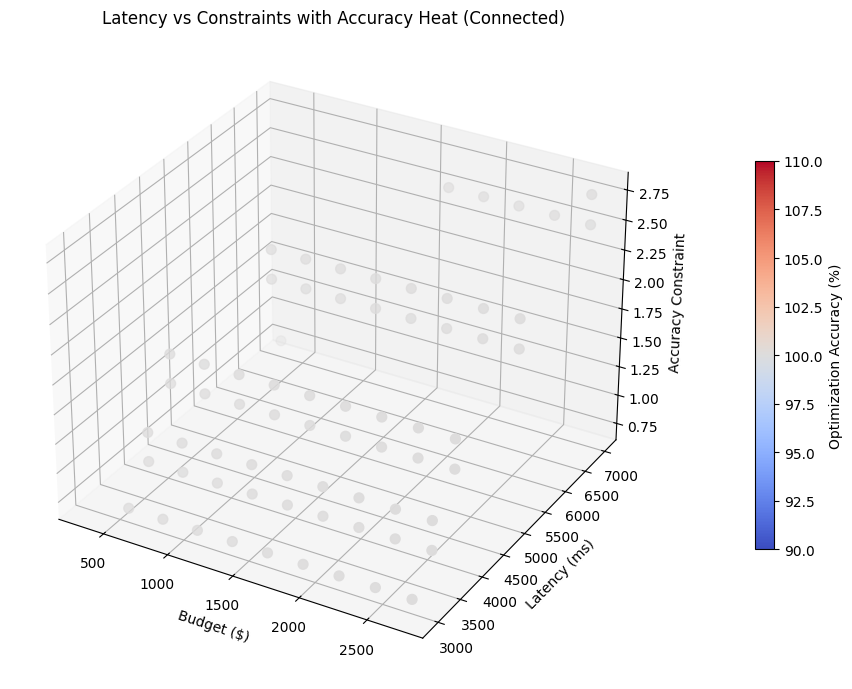

In [25]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np

budget = opt_curve_data_BPBC['Budget']
accuracy_constraint = opt_curve_data_BPBC['Accuracy_Constraint']
latency = opt_curve_data_BPBC['Best_Answer_RT']
optimization_accuracy = BPBC_accuracy

df = pd.DataFrame({
    "Budget": budget,
    "Accuracy_Constraint": accuracy_constraint,
    "Latency": latency,
    "Optimization_Accuracy": optimization_accuracy
})

df["Clipped_Latency"] = df["Latency"].clip(upper=7000)

df_sorted = df.sort_values("Budget")

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')


sc = ax.scatter(
    df_sorted["Budget"],
    df_sorted["Clipped_Latency"],
    df_sorted["Accuracy_Constraint"],
    c=df_sorted["Optimization_Accuracy"],
    cmap='coolwarm',
    s=50
)


ax.set_xlabel("Budget ($)")
ax.set_ylabel("Latency (ms)")
ax.set_zlabel("Accuracy Constraint")

cbar = fig.colorbar(sc, ax=ax, shrink=0.6, pad=0.1)
cbar.set_label("Optimization Accuracy (%)")

ax.set_title("Latency vs Constraints with Accuracy Heat (Connected)")

plt.tight_layout()
plt.show